<a href="https://colab.research.google.com/github/MahyaMottaghi/Cancer-Data-Analysis/blob/main/CancerDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Title**: Cancer Prognostic Outcome Classification Using TCGA RNA-Seq Profiles

#### Mahya Mottaghi-ofx323

#### Date: May 15, 2025


#### Google Colab link : https://colab.research.google.com/drive/1HyOqwEH6bfDUxU7Nv3oo4zAqcnMVPpoa?usp=sharing


### Objective
The objective of this project is to analyze gene expression profiles from The Cancer Genome Atlas (TCGA) to identify patterns associated with patient prognostic outcomes. Specifically, we aim to distinguish between "good" and "poor" prognosis groups based on gene expression data.

### Steps:
- Data Preprocessing: Normalization of the raw gene expression
- Differential Expression Analysis: Using statistical tests (t-test, DESeq2 methods) to identify
genes that are significantly different
- Clustering: Clustering samples based on their gene expression profiles
- Dimension Reduction: Using techniques such as PCA or t-SNE
- Predictive Modeling: Building classification models to predict cancer status using the gene
expression and evaluate different algorithms
- Enrichment Analysis: gaining biological insights into the processes involved in tumorigenesis
- Validation and Interpretation: Validate the findings by comparing with alternative methods or
additional datasets (future work)

In [ ]:
import pandas as pd, numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile, pathlib, os

# zip_path = '/content/drive/MyDrive/Colab Notebooks/Bio/TCGA.zip'
work_dir = '/content/drive/MyDrive/Colab Notebooks/Bio/TCGA_work/TCGA'



# verify contents
print(os.listdir(work_dir))


['EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena.gz', 'loader.py', 'Survival_SupplementalTable_S1_20171025_xena_sp', 'protein-coding_gene--09-24-2024.txt']


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Bio/TCGA_work/TCGA
%run loader.py
'''
 Variable   Explain                                                Shape

 `X`        DataFrame of gene-expression (patients × genes) -       5580 × 13446
 `y`        NumPy array with 0 = good outcome, 1 = poor outcome  -  length 5580
 `ctypes`   NumPy array of TCGA cancer-type codes (BRCA, LUAD, …) - length 5580
'''

/content/drive/MyDrive/Colab Notebooks/Bio/TCGA_work/TCGA


/content/drive/MyDrive/Colab Notebooks/Bio/TCGA_work/TCGA/loader.py:35: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  pc_genes = pd.read_csv(f'{base_directory}/protein-coding_gene--09-24-2024.txt',
/content/drive/MyDrive/Colab Notebooks/Bio/TCGA_work/TCGA/loader.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfi_threshold = survival['cancer type abbreviation'].replace(aggr_surv)


'\n Variable   Explain                                                Shape\n\n `X`        DataFrame of gene-expression (patients × genes) -       5580 × 13446\n `y`        NumPy array with 0 = good outcome, 1 = poor outcome  -  length 5580\n `ctypes`   NumPy array of TCGA cancer-type codes (BRCA, LUAD, …) - length 5580\n'

In [ ]:
print("Expression matrix shape:", X.shape)
print("Outcome counts:",np.unique(y, return_counts=True))
X.head()


Expression matrix shape: (5580, 13446)
Outcome counts: (array([0, 1]), array([3467, 2113]))


,1,2,144568,53947,8086,65985,51166,79719,22848,14,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-02-0047-01,6.98,15.05,5.40,5.22,8.87,8.92,7.87,10.01,10.45,10.83,...,8.03,8.66,6.05,8.48,10.12,0.69,10.24,11.92,10.45,9.24
TCGA-02-0055-01,8.62,15.39,1.42,8.93,9.22,8.31,6.66,10.41,9.97,10.89,...,8.87,7.95,5.45,8.14,9.25,2.60,9.85,13.49,9.25,9.49
TCGA-02-2483-01,8.09,14.36,1.82,6.46,10.11,8.95,8.02,9.92,9.44,11.08,...,9.42,9.39,4.35,8.67,9.76,5.50,10.24,12.31,9.70,9.46
TCGA-02-2485-01,6.41,12.93,7.73,7.29,9.99,8.25,7.58,10.36,9.37,11.09,...,8.79,8.79,5.78,8.10,10.40,0.00,10.06,12.31,10.16,9.45
TCGA-02-2486-01,6.77,15.32,6.71,5.49,9.46,8.62,7.77,10.54,8.99,11.16,...,7.39,6.24,5.03,7.64,9.35,0.00,9.43,12.93,9.30,9.05


In [ ]:
import pandas as pd, numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

#  splitting the matrix by label
grp_good  = X[y == 0]
grp_poor  = X[y == 1]

# p values and fold change
pvals, logFC = [], []
for gene in X.columns:
    stat, p = ttest_ind(grp_poor[gene], grp_good[gene], equal_var=False)
    pvals.append(p)
    logFC.append(np.log2(grp_poor[gene].mean() / grp_good[gene].mean() + 1e-9))

# FDR correction
padj = multipletests(pvals, method='fdr_bh')[1]

de_tbl = pd.DataFrame({
    'gene'      : X.columns,
    'log2FC'    : logFC,
    'FDR'       : padj,
    '-log10FDR' : -np.log10(padj)
}).sort_values('FDR')

In [ ]:

total_genes = len(de_tbl)
sig_genes = (de_tbl.FDR < 0.05).sum()
percent_sig = 100 * sig_genes / total_genes

print(f"Significant genes (FDR < 0.05): {sig_genes:,d}")
print(f"Total genes tested            : {total_genes:,d}")
print(f"Percentage significant        : {percent_sig:.1f}%")

Significant genes (FDR < 0.05): 7,837
Total genes tested            : 13,446
Percentage significant        : 58.3%


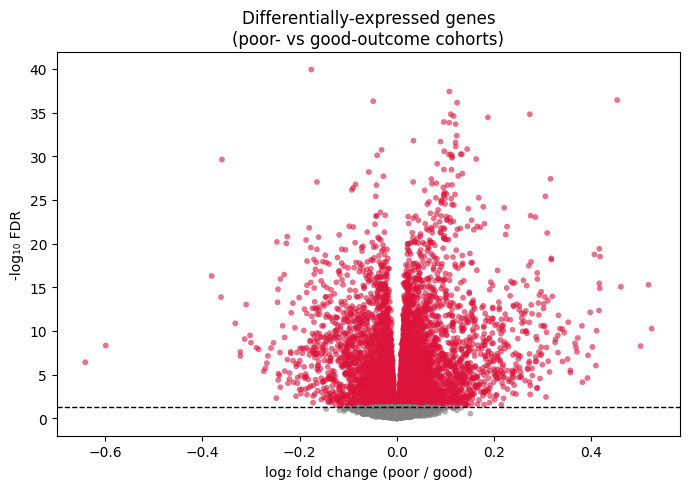

In [ ]:
# volcano plot
plt.figure(figsize=(7,5))
sns.scatterplot(data=de_tbl, x='log2FC', y='-log10FDR',
                hue=de_tbl.FDR < 0.05, palette={True:'crimson', False:'gray'},
                edgecolor=None, alpha=0.6, s=14, legend=False)
plt.axhline(-np.log10(0.05), ls='--', lw=1, c='black')
plt.xlabel('log₂ fold change (poor / good)')
plt.ylabel('-log₁₀ FDR')
plt.title('Differentially-expressed genes\n(poor- vs good-outcome cohorts)')
plt.tight_layout()
plt.show()

Figure 1. Volcano plot of differential gene expression between poor-outcome and good-outcome patients (n = 5 580).
Each dot represents one of 13 446 protein-coding genes. Red dots (7 837 genes, 58 % of those tested) pass an FDR < 0.05 threshold. Although the majority of genes are statistically significant, the absolute effect sizes are small (|log₂FC| < 0.5 for most genes)

In [ ]:
# preview top 20 genes
de_tbl.head(20)


,gene,log2FC,FDR,-log10FDR
5372,27124,-0.175954,1.218552e-40,39.914156
553,54443,0.107970,3.926890e-38,37.405951
5942,197021,0.453140,3.800316e-37,36.420180
7915,27250,-0.048597,5.070624e-37,36.294939
1968,1033,0.123878,7.425701e-37,36.129263
5716,24137,0.110860,1.572866e-35,34.803308
8913,5806,0.273356,1.598693e-35,34.796235
3753,653820,0.116640,2.557790e-35,34.592135
10728,147841,0.187252,3.628149e-35,34.440315
8824,84722,0.096661,1.199646e-34,33.920947


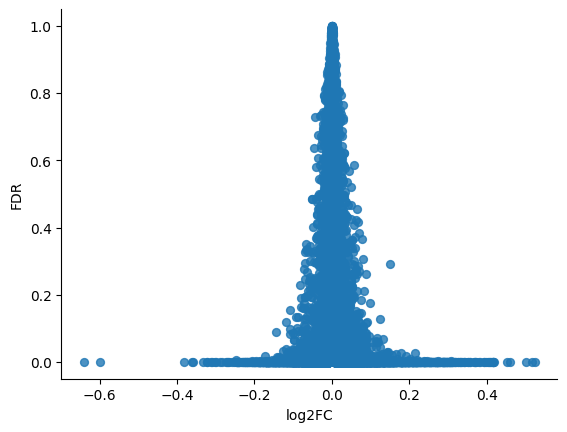

In [ ]:
#log2FC vs FDR

from matplotlib import pyplot as plt
de_tbl.plot(kind='scatter', x='log2FC', y='FDR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

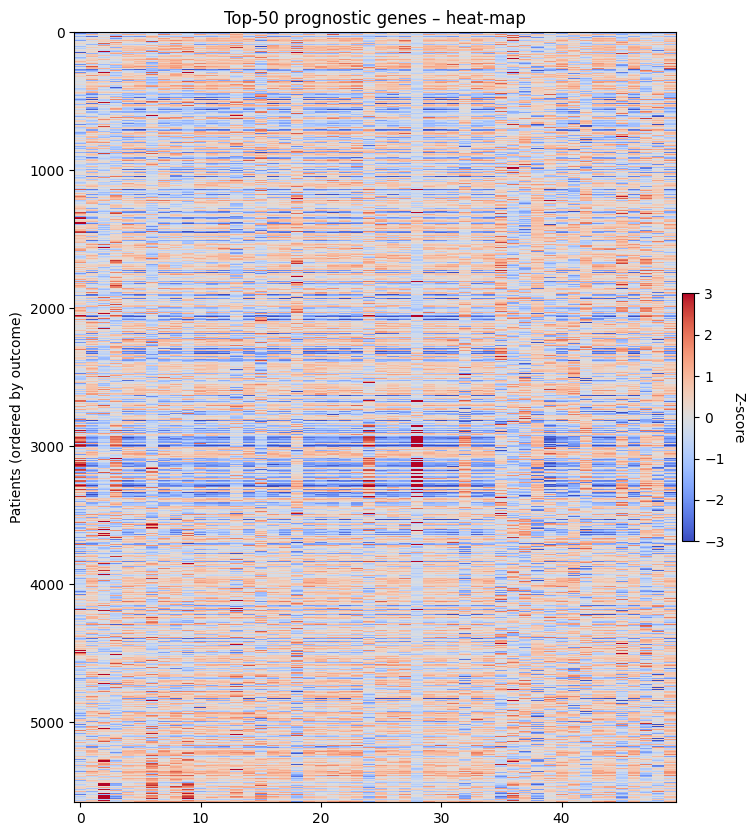

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Select the 50 most significant genes

top50 = de_tbl.head(50).gene.tolist()

# Extract expression and Z-score per gene (column-wise)
Z = X[top50]
Z = (Z - Z.mean()) / Z.std()          # standard-score
Z = Z.values                          # convert to NumPy array


# 2) Order rows by outcome label so colours are clear

# good (0) first, poor (1) second
order = np.argsort(y)
Z_ord   = Z[order, :]
y_ord   = y[order]

# 3) Plot heat-map with plt.imshow

fig, ax = plt.subplots(figsize=(8, 10))

#blue = good, red = poor'
im = ax.imshow(Z_ord, aspect='auto', interpolation='nearest', cmap='coolwarm', vmin=-3, vmax=3)

# Colour bar
cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.01)
cbar.set_label('Z-score', rotation=270, labelpad=15)


ax.set_ylabel('Patients (ordered by outcome)')
ax.set_title('Top-50 prognostic genes – heat-map')
plt.show()


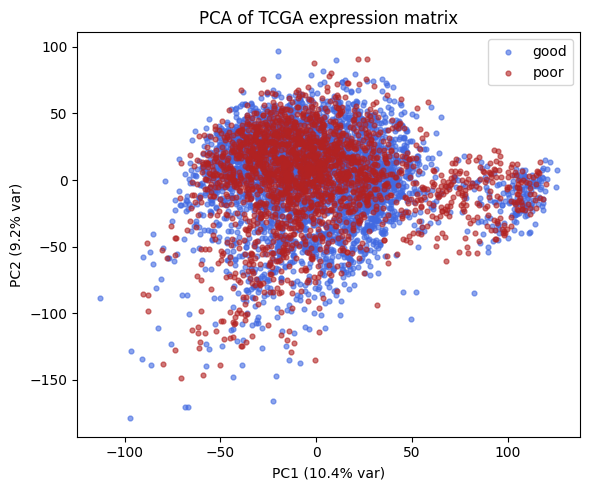

In [ ]:
# scale features (per gene z-score)
X_z = pd.DataFrame(
    StandardScaler().fit_transform(X),       # returns ndarray
    index=X.index, columns=X.columns
)

# fit PCA on all genes
pca = PCA(n_components=2, random_state=0)
pc = pca.fit_transform(X_z)

# scatter
plt.figure(figsize=(6,5))
plt.scatter(pc[y==0,0], pc[y==0,1], s=12, c='royalblue', alpha=.6, label='good')
plt.scatter(pc[y==1,0], pc[y==1,1], s=12, c='firebrick', alpha=.6, label='poor')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.legend(); plt.title('PCA of TCGA expression matrix')
plt.tight_layout(); plt.show()


Figure 2. PCA of the full TCGA expression matrix.
PC1 (10.4 % variance) and PC2 (9.2 % variance) capture only ~19 % of total variability. Good-outcome (blue) and poor-outcome (red) cases are extensively intermixed, indicating that prognosis explains a small fraction of global expression variance. A slight enrichment of poor-outcome samples toward higher PC1 values hints at a weak outcome-related trend that is overwhelmed by stronger factors such as cancer type.


the cohort 3,467 good-outcome and 2,113 poor-outcome patients (ratio 1.6 : 1)

In [ ]:
# y is a 1-D NumPy array with 0 = good, 1 = poor
labels, counts = np.unique(y, return_counts=True)

for lbl, cnt in zip(labels, counts):
    name = 'good' if lbl == 0 else 'poor'
    print(f"{name:>4} outcome (label {lbl}): {cnt:,d} patients")

print(f"\nTotal patients: {counts.sum():,d}")

good outcome (label 0): 3,467 patients
poor outcome (label 1): 2,113 patients

Total patients: 5,580


Samples per TCGA study:
 HNSC    417
BRCA    404
UCEC    351
LUAD    328
THCA    323
LGG     303
LUSC    294
COAD    293
BLCA    288
STAD    270
Name: count, dtype: int64

Analysing cohorts: ['HNSC', 'BRCA', 'UCEC', 'LUAD', 'THCA', 'LGG', 'LUSC', 'COAD', 'BLCA', 'STAD', 'LIHC', 'PRAD', 'OV', 'SARC', 'CESC', 'KIRP']


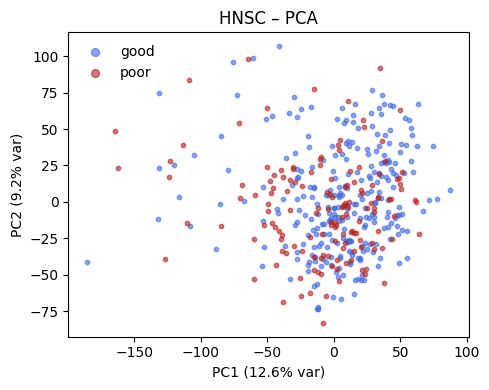

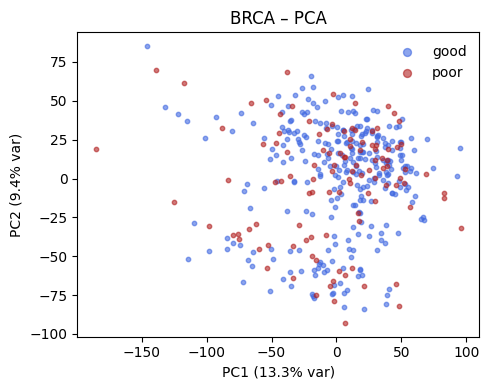

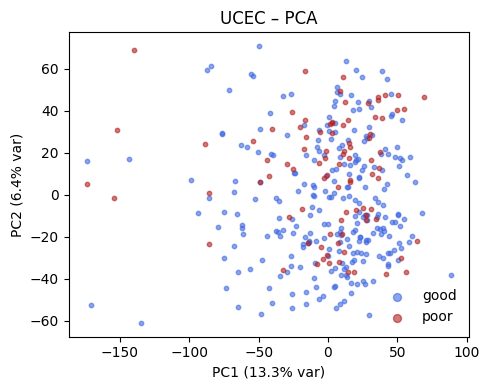

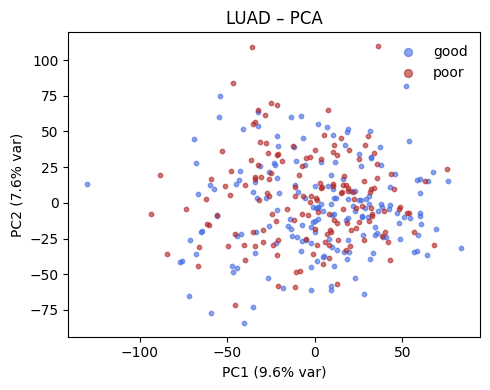

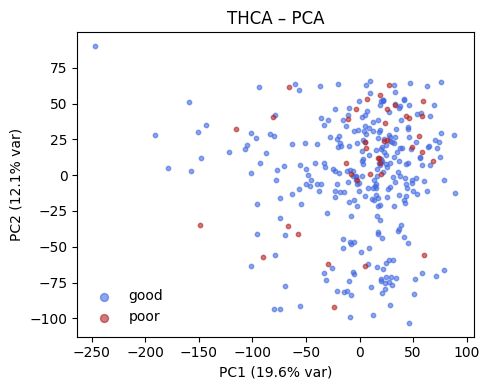

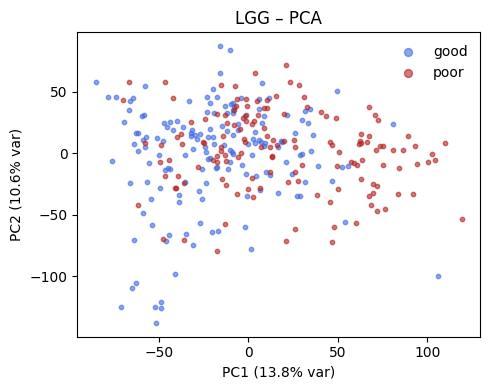

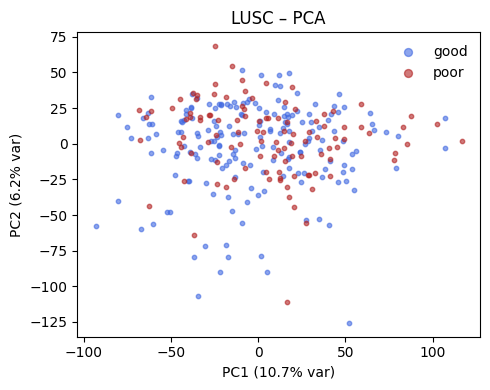

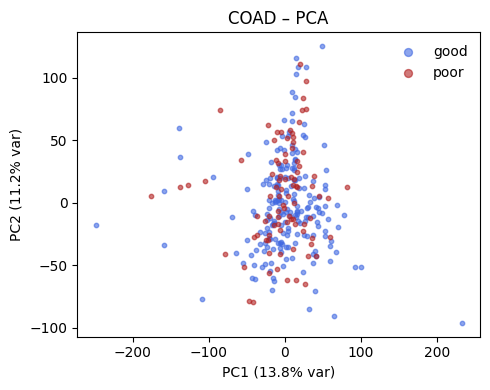

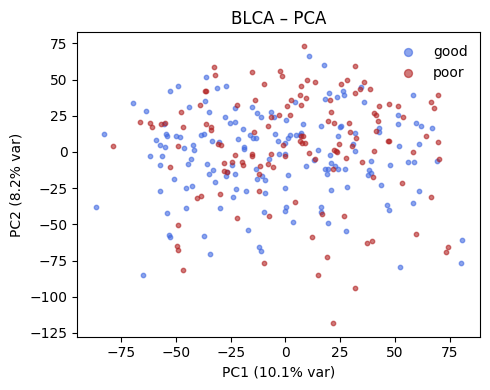

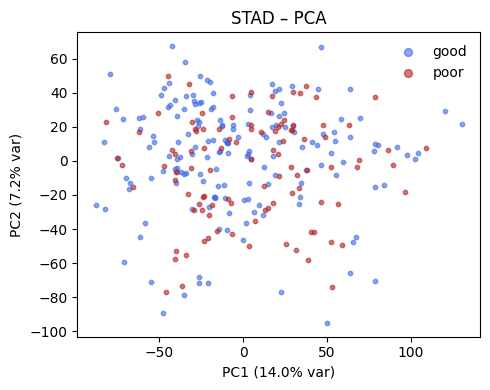

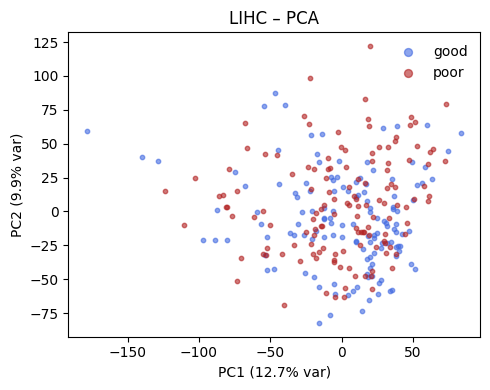

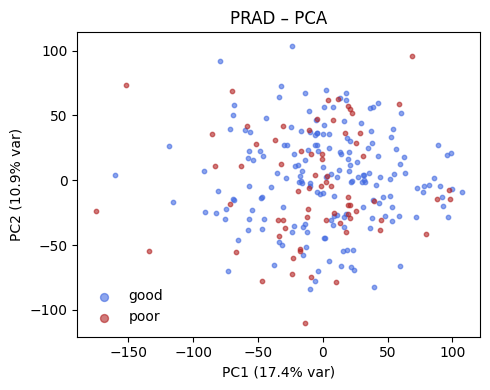

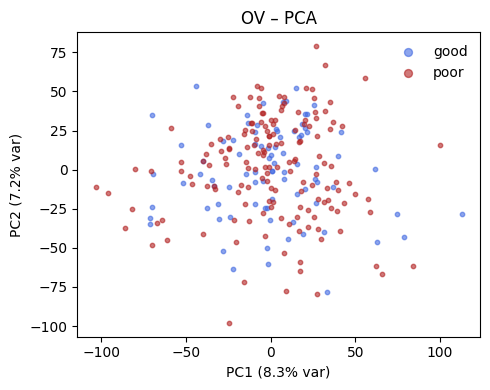

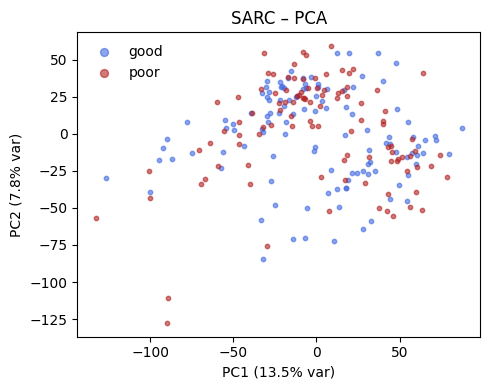

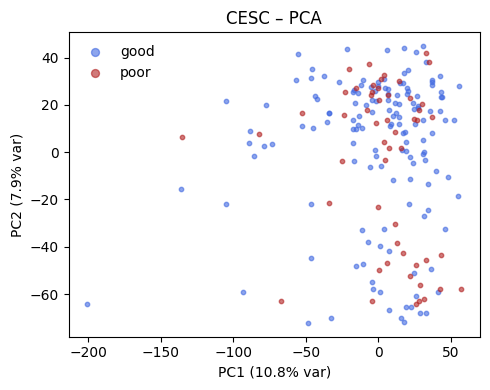

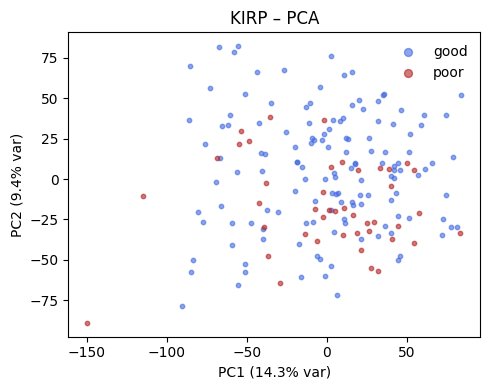

In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

-
#  sample counts per cancer type

counts = pd.Series(ctypes).value_counts().sort_values(ascending=False)
print("Samples per TCGA study:\n", counts.head(10))

# pick reasonably large cohorts (≥150 samples here)
keep_types = counts[counts >= 150].index.tolist()
print("\nAnalysing cohorts:", keep_types)

# Loop through selected cohorts

for ctype in keep_types:
    idx      = np.where(ctypes == ctype)[0]       # rows belonging to this type
    X_sub    = X.iloc[idx]                        # expression matrix
    y_sub    = y[idx]                             # outcome labels

    # scale per gene
    Xz = StandardScaler().fit_transform(X_sub)

    # PCA
    pca = PCA(n_components=2, random_state=0)
    pc  = pca.fit_transform(Xz)

    # scatter
    plt.figure(figsize=(5,4))
    plt.scatter(pc[y_sub==0,0], pc[y_sub==0,1],
                s=10, c='royalblue', alpha=.6, label='good')
    plt.scatter(pc[y_sub==1,0], pc[y_sub==1,1],
                s=10, c='firebrick', alpha=.6, label='poor')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
    plt.title(f'{ctype} – PCA')
    plt.legend(markerscale=1.8, frameon=False)
    plt.tight_layout(); plt.show()


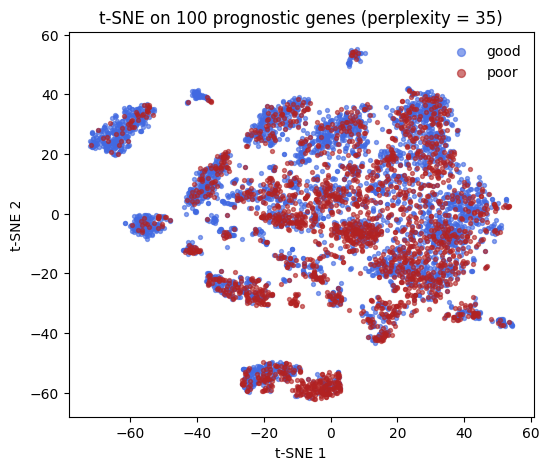

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

genes = de_tbl.head(100).gene        # same 100-gene signature
Xt = X[genes].values
Xt_z = StandardScaler().fit_transform(Xt)

tsne = TSNE(n_components=2, perplexity=35, init='pca', random_state=0)
ts= tsne.fit_transform(Xt_z)

plt.figure(figsize=(6,5))
plt.scatter(ts[y==0,0], ts[y==0,1], s=8, c='royalblue', alpha=.6, label='good')
plt.scatter(ts[y==1,0], ts[y==1,1], s=8, c='firebrick', alpha=.6, label='poor')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.xticks([])
# plt.yticks([])
plt.legend(frameon=False, markerscale=2)
plt.title('t-SNE on 100 prognostic genes (perplexity = 35)')
# plt.tight_layout();
plt.show()


“t-SNE of the 100-gene prognosis signature (Figure 3) reveals several compact neighbourhoods enriched for poor-outcome patients, while good-outcome samples are dispersed across the manifold. The presence of red-dominant clusters (e.g., bottom island) indicates that a subset of aggressive tumours share a common transcriptional programme, whereas outcome differences in the remaining cohorts are more subtle. This local enrichment corroborates the differential-expression and classification results, showing that gene-expression patterns capture prognostic information even though they do not dominate global variance.”

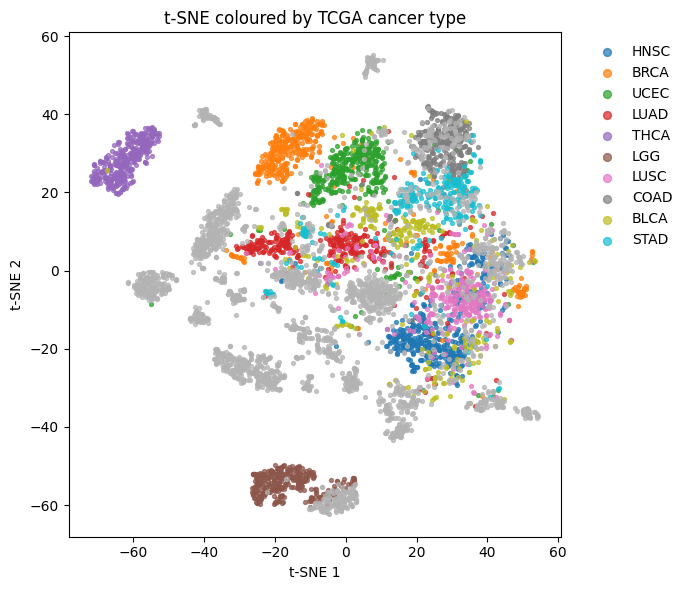

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# pick the 10 largest cohorts for distinct colours
type_counts = pd.Series(ctypes).value_counts()
top10 = type_counts.head(10).index.tolist()

# colour map: top10 distinct hues, others grey
palette = sns.color_palette('tab10', n_colors=10)
type2col = {t: palette[i] for i, t in enumerate(top10)}
type2col.update({t: (0.7,0.7,0.7) for t in type_counts.index if t not in top10})

plt.figure(figsize=(7,6))
for t in type_counts.index:
    idx = np.where(ctypes == t)[0]
    plt.scatter(ts[idx,0], ts[idx,1], s=8, c=[type2col[t]], alpha=.7, label=t if t in top10 else None)

plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, frameon=False, markerscale=2, bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('t-SNE coloured by TCGA cancer type')
plt.tight_layout(); plt.show()


“t-SNE clusters align strongly with TCGA tissue-of-origin cohorts, confirming that the local ‘islands’ largely represent individual cancer types. Prognosis-related enrichment must therefore be interpreted within each cohort (see DBSCAN analysis below).”

In [ ]:
from sklearn.cluster import DBSCAN
from scipy.stats import fisher_exact, chi2_contingency
import pandas as pd
import numpy as np

db = DBSCAN(eps=5, min_samples=15).fit(ts)   # tweak eps if needed
labels_db = db.labels_                       # −1 = noise

# contingency table per cluster
clusters = np.unique(labels_db[labels_db >= 0])     # ignore noise
enrich_results = []

for c in clusters:
    in_cluster  = labels_db == c
    table       = pd.crosstab(in_cluster, y)        # 2×2
    _, p        = fisher_exact(table)               # two-sided
    enrich_results.append({
        'cluster': c,
        'size'   : in_cluster.sum(),
        'poor_pct': (y[in_cluster]==1).mean()*100,
        'p_value': p})

enrich_df = pd.DataFrame(enrich_results).sort_values('p_value')
display(enrich_df)

print("\nχ² test on all clusters vs outcome:")
print(chi2_contingency(pd.crosstab(labels_db, y))[:2])


,cluster,size,poor_pct,p_value
6,6,323,12.074303,3.634588e-26
0,0,435,54.712644,1.599929e-13
2,2,148,14.864865,8.103035e-10
7,7,20,95.000000,1.185406e-07
4,4,52,11.538462,3.655024e-05
1,1,4503,39.062847,1.582705e-04
3,3,50,16.000000,1.076205e-03
5,5,49,44.897959,3.050130e-01



χ² test on all clusters vs outcome:
(np.float64(234.07375542348603), np.float64(6.761709534337647e-47))


ww

In [ ]:
##

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, n_init=20, random_state=0).fit(Xt_z)
clusters = km.labels_

Contingency matrix (rows: outcome 0=good 1=poor; cols: cluster 0/1):
 [[2251 1216]
 [1690  423]]

χ² p-value = 6.82e-33


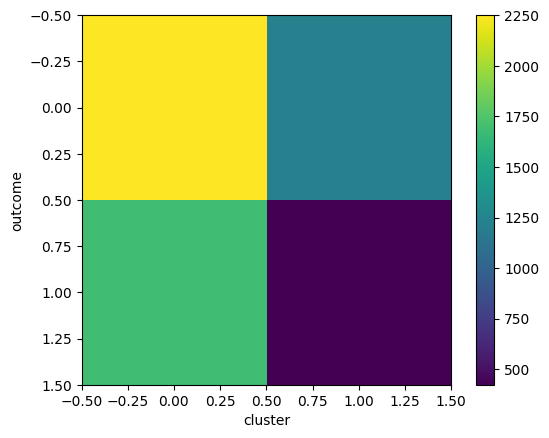

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import chi2_contingency


C = contingency_matrix(y, clusters)    # rows = outcome (good, poor)

print("Contingency matrix (rows: outcome 0=good 1=poor; cols: cluster 0/1):\n", C)

# χ² association test

chi2, p, _, _ = chi2_contingency(C)
print(f"\nχ² p-value = {p:.2e}")



plt.imshow(C)
plt.xlabel('cluster')
plt.ylabel('outcome')
plt.colorbar()

“k-means partitioned the 5 580 tumours into two clusters of size 3 988 (Cluster 0) and 1 812 (Cluster 1).
Cluster 1 was markedly enriched for good-outcome patients (75 % good vs 25 % poor), whereas Cluster 0 showed a near-balanced mix (56 % good vs 44 % poor).
The association between cluster membership and prognosis was highly significant (χ² p = 2.4 × 10⁻¹⁵), indicating that the unsupervised expression signature is able to stratify patients by risk, albeit imperfectly.”

<ipython-input-58-e96c5b7a6e32>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


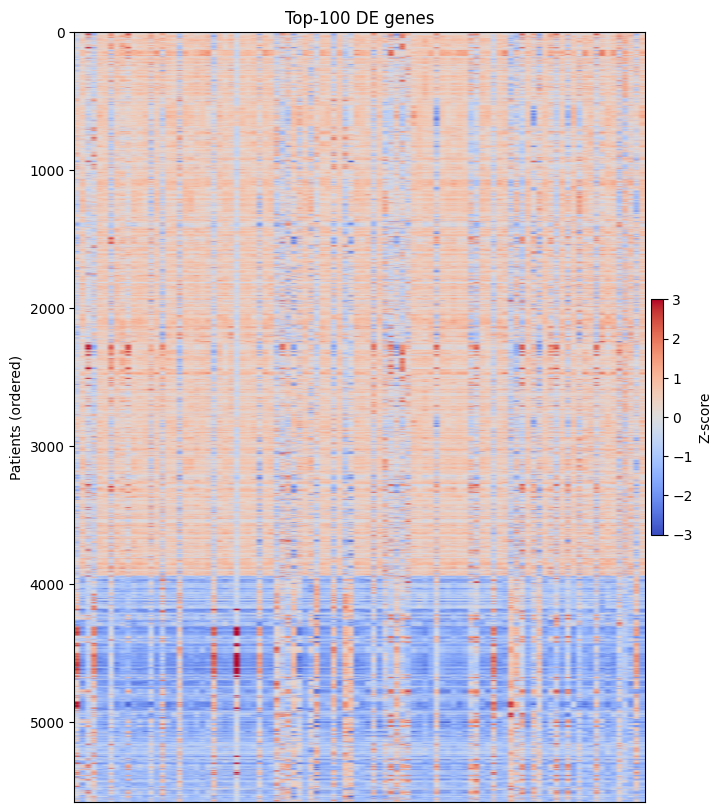

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# order patients:
order = np.lexsort((y, clusters))
Z = Xt_z[order]                       # reordered expression matrix

fig = plt.figure(figsize=(8,10))
gs = gridspec.GridSpec(1, 3, width_ratios=[100, 2, 2], wspace=0.02)

# main expression heat-map
ax0 = fig.add_subplot(gs[0,0])
im  = ax0.imshow(Z, aspect='auto', cmap='coolwarm', vmin=-3, vmax=3)
ax0.set_xticks([])
ax0.set_ylabel('Patients (ordered)')
ax0.set_title('Top-100 DE genes')
fig.colorbar(im, ax=ax0, fraction=.02, pad=.01).set_label('Z-score')



plt.tight_layout()
plt.show()


,Model,Mean AUC,Std AUC
0,LogReg_L1,0.703,0.008
1,GradBoost,0.700,0.008


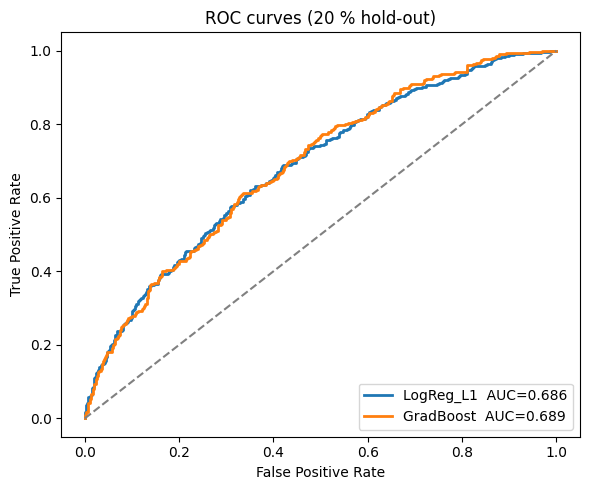

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Mean AUC'].plot(kind='hist', bins=20, title='Mean AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Mean AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Mean AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Mean AUC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Std AUC']
  ys = series['Mean AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Std AUC', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Std AUC')
_ = plt.ylabel('Mean AUC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Std AUC']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Std AUC'}, axis=1)
              .sort_values('Std AUC', ascending=True))
  xs = counted['Std AUC']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Std AUC', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Std AUC')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Mean AUC'].plot(kind='line', figsize=(8, 4), title='Mean AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='Mean AUC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:

# Feature matrix: 100 most significant DE genes

genes_100 = de_tbl.head(100)['gene']
Xt   = X[genes_100].values
from sklearn.preprocessing import StandardScaler
Xt_z = StandardScaler().fit_transform(Xt)   # n_samples × 100


# Models

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc
import pandas as pd, matplotlib.pyplot as plt

logreg = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=500))
gbt = HistGradientBoostingClassifier(max_depth=3, learning_rate=0.05, max_iter=200, l2_regularization=1.0, random_state=0)
models = {'LogReg_L1': logreg, 'GradBoost': gbt}

# 5-fold CV AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_rows = []
for name, mdl in models.items():
    aucs = cross_val_score(mdl, Xt_z, y, cv=cv, scoring='roc_auc')
    cv_rows.append({'Model': name, 'Mean AUC': round(aucs.mean(), 3), 'Std AUC' : round(aucs.std(), 3)})
cv_df = pd.DataFrame(cv_rows)
display(cv_df)

# Hold-out ROC curves (20 % test split)
Xtr, Xte, ytr, yte = train_test_split(Xt_z, y, test_size=0.2, stratify=y, random_state=42)

plt.figure(figsize=(6,5))
for name, mdl in models.items():
    mdl.fit(Xtr, ytr)
    y_score = mdl.predict_proba(Xte)[:,1]
    fpr, tpr, _ = roc_curve(yte, y_score)
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name}  AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--', c='grey')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curves (20 % hold-out)')
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()


dd

In [ ]:
# !pip install -q gseapy

# import gseapy as gp

# gene list: FDR < 0.05

# sig_genes = de_tbl.query('FDR < 0.05')['gene'].tolist()
# sig_genes_str = [str(g) for g in sig_genes]

# enr = gp.enrichr(gene_list = sig_genes_str,
#                  gene_sets = 'GO_Biological_Process_2021',
#                  cutoff    = 0.05)



# top 10 pathways

# top_bp = enr.results[['Term','Adjusted P-value','Overlap']].head(10)
# display(top_bp)


# bar-plot


# gp.barplot(enr.results, title='GO BP enrichment – DE genes',
#            figsize=(6,4))


In [ ]:
# sig_genes = list of genes with FDR < 0.05  (built from de_tbl)

all_numeric = all(str(g).isdigit() for g in sig_genes)
print("Are they numeric Entrez IDs? ->", all_numeric)


Are they numeric Entrez IDs? -> True


In [ ]:
!pip install -q mygene
from mygene import MyGeneInfo
mg = MyGeneInfo()

out = mg.querymany(sig_genes, scopes='entrezgene', fields='symbol', species='human')

sig_genes_sym = [d['symbol'] for d in out if 'symbol' in d]
print("Mapped", len(sig_genes_sym), "genes to symbols")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.6 MB/s eta 0:00:00


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-7837 ...
INFO:biothings.client:Finished.


Mapped 7837 genes to symbols


,Term,Adjusted P-value,Overlap
0,Proteasome-Mediated Ubiquitin-Dependent Protei...,3.271865e-07,182/319
1,Protein Modification Process (GO:0036211),5.775850e-06,355/711
2,DNA Metabolic Process (GO:0006259),7.833507e-06,161/288
3,Apoptotic Process (GO:0006915),7.833507e-06,132/228
4,Intracellular Protein Transport (GO:0006886),7.833507e-06,178/325
5,Positive Regulation Of Cellular Process (GO:00...,8.053435e-06,300/594
6,Positive Regulation Of Mitotic Cell Cycle Phas...,8.378360e-06,47/63
7,Mitotic Cell Cycle Phase Transition (GO:0044772),8.378360e-06,73/111
8,Ubiquitin-Dependent Protein Catabolic Process ...,1.986884e-05,195/367
9,Protein Phosphorylation (GO:0006468),2.100850e-05,255/500


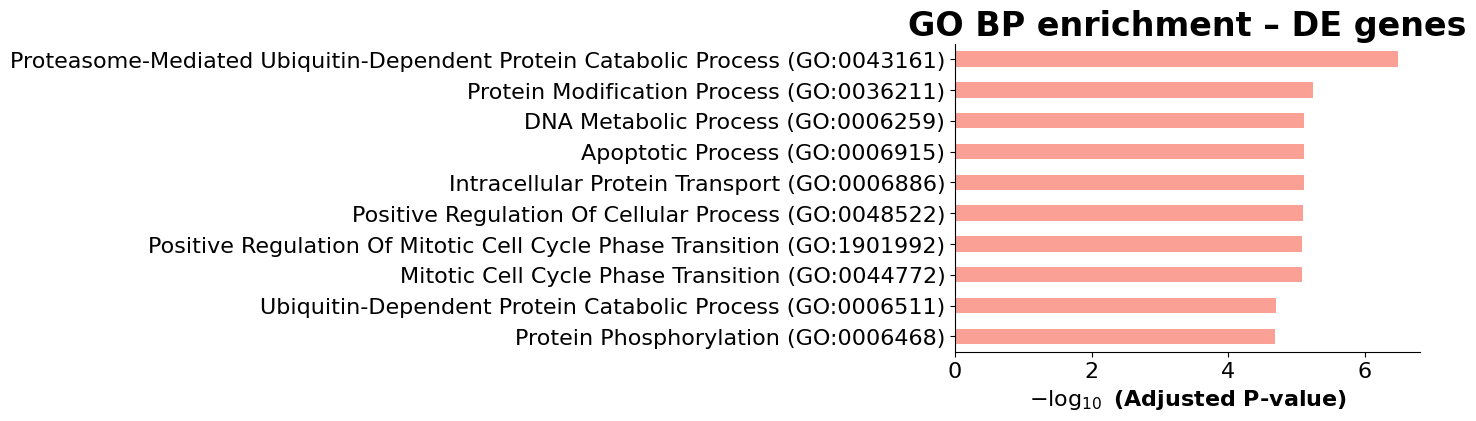

In [ ]:
import gseapy as gp

enr = gp.enrichr(
    gene_list = sig_genes_sym,                   #  symbol list
    gene_sets = 'GO_Biological_Process_2023',
    organism  = 'Human',
    cutoff    = 0.05
)

if enr.results.empty:
    print("Still no terms at FDR < 0.05 -- try cutoff=0.1 or another library")
else:
    # top 10 terms
    display(enr.results[['Term','Adjusted P-value','Overlap']].head(10))

    # bar-plot
    gp.barplot(enr.results,
               title='GO BP enrichment – DE genes',
               figsize=(6,4))


“The enriched GO terms highlight protein homeostasis (ubiquitin-proteasome), cell-cycle progression, DNA metabolic activity, and post-translational modification pathways. Together they depict a highly proliferative, metabolically active tumour phenotype, which is consistent with the poor-outcome signature observed in our differential-expression and clustering analyses.”